# The Boundary Element Method (BEM)

:::{note}
You can run this code directly in your browser by clicking on the rocket logo ( <i class="fas fa-rocket"></i> ) at the top of the page, and clicking 'Binder'. This will open a Jupyter Notebook in a [Binder](https://mybinder.org/) environment which is set up to contain everything you need to run the code. **Don't forget to save a local copy if you make any changes!**

If you prefer, you can download the Jupyter Notebook file to run locally, by clicking the download logo ( <i class="fas fa-download"></i> ) at the top of the page and selecting '.ipynb'.

If you are new to using Jupyter Notebooks, [this guide](https://www.dataquest.io/blog/jupyter-notebook-tutorial/) will help you get started.
:::

## Prerequisites

To understand the basic principles explained in this tutorial, you should:
* Have an understanding of the exterior Helmholtz scattering problem
* Have a basic understanding of the midpoint rule, for approximating integrals
* Be comfortable using ```numpy```

## Introduction

This notebook introduces the **Boundary Element Method** (BEM), by a simple numerical example. The main idea behind is to use Green's identities to represent the (unknown) scattered wave in terms of an unknown which is defined only on the boundary of our domain. For example, if we are modelling scattering by a sphere, the unknown is a function which lives on the surface of the sphere. BEM involves applying a finite element method to approximate this unknown on the boundary, hence the name. This is advantagous for the following two reasons:
* We have reduced the dimension of our problem by one, so meshing is considerably simpler, and fewer degrees of freedom are required
* We do not need to worry about meshing an unbounded domian, constructing an artificial boundary, etc.


## Setup

This example is intended to be from first principles, so we will only use methods from three of the main python libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True # use TeX in plot formatting

## Step one: Obtain a representation for the solution in terms of boundary data

For our scattering problem, we consider an incident wave $u^i(x)$ impinging on an obstacle $\Omega\subset\mathbb{R}^n$, where $n=2,3$. Our starting point is the Helmholtz equation
$$\label{eq:1}
(\Delta+k^2)u=0,
$$
where $u$ denotes the total field, and $u^s=u-u^i$ is the scattered field, which satisfies the Sommerfeld radiation condition.

Applying [Green's third identity](https://en.wikipedia.org/wiki/Green's_identities#Green's_third_identity) we obtain the representation:
$$
u(x) = u^i(x) - \int_\Gamma \left[\Phi(x,y)\frac{\partial u}{\partial n}(y) - \frac{\partial \Phi(x,y)}{\partial n(y)}u(y)\right]~\mathrm{d}s(y),\quad x\in\mathbb{R}^n\setminus\Omega,
$$
where $\frac{\partial}{\partial n}$ denotes the outward normal derivative, $\Gamma$ denotes the boundary of $\Omega$, and $\Phi$ denotes the fundamental solution
$$
\Phi(x,y) = \left\{
\begin{array}{ll}
\frac{\mathrm{i}}{4}H^{(1)}_0(k|x-y|),&\quad n=2,\\
\frac{\mathrm{e}^{\mathrm{i}k|x-y|}}{4\pi|x-y|},&\quad n=3,
\end{array}
\right.
$$
where $H^{(1)}_0$ is the [Hankel function](https://mathworld.wolfram.com/HankelFunctionoftheFirstKind.html) of the first kind order zero. You probably recognise the function for $n=3$, but if you haven't seen $H^{(1)}_0$ before, it looks like the ripples on the surface of a lake after you drop a pebble into the water:

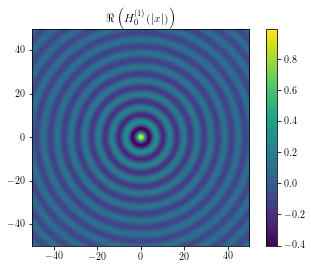

In [2]:
from scipy.special import hankel1 as H1
t = np.linspace(-50,50,1000)
X,Y = np.meshgrid(t,t)
ripples = plt.imshow(np.real(H1(0,np.sqrt(X**2+Y**2))),extent =[t.min(), t.max(), t.min(), t.max()])
plt.colorbar(ripples)
plt.title(r'$\Re\left(H_0^{(1)}(|x|)\right)$');

For this simple example, we will consider scattering by a circle in two-dimensions, with sound-soft aka Dirichlet boundary conditions. This means that $u=0$ on $\Gamma$, so the BIE above simplifies to
$$
u(x) = u^i(x) - \int_\Gamma \Phi(x,y)\frac{\partial u}{\partial n}(y)~\mathrm{d}s(y),\quad x\in\mathbb{R}^2\setminus\Omega.
$$
The integral may be interpreted as lots of tiny speakers $\Phi(x,y)$ on our surface $\Gamma$, whilst $\frac{\partial u}{\partial n}(y)$ can be interpreted as the volume of these speakers. We will choose our incoming wave to be an incident plane wave, $u^i(x):=\mathrm{e}^{\mathrm{i} k x\cdot d}$, where $d\in\mathbb{R}^2$ is a unit vector which represents the direction of propagation.

In [3]:
k = 5.0 # wavenumber
d = np.array([1.0,0.0]) # incident direction

In [4]:
Phi = lambda x,y: 1j/4*H1(0,k*np.linalg.norm(np.array(x)-np.array(y)))
ui = lambda x: np.exp(1j*k*np.dot(x,d))

## Step two: Reformulate as a problem on the boundary $\Gamma$
Remember, our long-term aim is to approximate $\frac{\partial u}{\partial n}$, then we can plug that approximation into the above equation, to obtain an approximation for $u(x)$. To get an equation we can solve, we take the limit of the above equation as $x$ tends to $\Gamma$ and rearrange, to obtain a **boundary integral equation** (BIE):
$$
\int_\Gamma \Phi(x,y)\frac{\partial u}{\partial n}(y)~\mathrm{d}s(y)=u^i(x),\quad x\in\Gamma.
$$
A BEM is an approximation of an equation of this type, defined on the boundary $\Gamma$. Before approximating, we can parametrise the circle $\Gamma$ by $\theta\in[0,2\pi)\to x\in\Gamma$ in the natural way, $x(\theta)=[\cos(\theta),\sin(\theta)]$, to rewrite the above BIE in terms of a one-dimensional parameter
$$
\int_0^{2\pi} \tilde\Phi(\theta,\vartheta)\frac{\partial u}{\partial n}(y(\vartheta))~\mathrm{d}\vartheta=u^i(x(\theta)),\quad \theta\in[0,2\pi),
$$
where $\tilde\Phi(\theta,\vartheta):=\Phi(x(\theta),y(\vartheta))$ is purely to keep things a bit simpler.
There are many BEMs, but for the purpose of this example, I will choose the simplest one I can think of.

In [5]:
circle_map = lambda theta: [np.cos(theta), np.sin(theta)]
ui_angular = lambda theta: ui(circle_map(theta))
Phi_tilde = lambda theta,vartheta: Phi(circle_map(theta),circle_map(vartheta))

## Step three: Approximate the boundary data

Choose $N$ equispaced points on the circle $\theta_n=nh$ where $h:=2\pi/N$ for $n=0,\ldots,N-1$. For our approximation, we specify that the above BIE must hold exactly at these points. This is known as a **collocation  BEM**, and $\theta_n$ are the **collocation points**:
$$
\int_0^{2\pi} \tilde\Phi(\theta_n,\vartheta)v_h(\vartheta)~\mathrm{d}\vartheta=u^i(x(\theta_n)),\quad n=0,\ldots,N-1,
$$
where we choose the details of our approximation $v^{(h)}(\theta)\approx\frac{\partial u}{\partial n}(y(\theta))$ next.

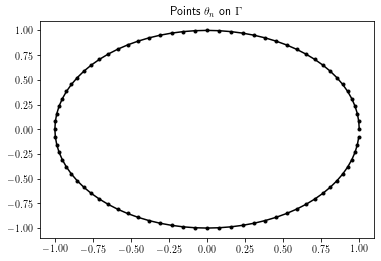

In [6]:
N=80 # number of collocation points
theta = np.linspace(0,2*np.pi,N,endpoint=False) # equispaced points on circle
h = 2*np.pi/N # meshwidth
plt.plot(np.cos(theta),np.sin(theta),'k.-')
plt.title(r'Points $\theta_n$ on $\Gamma$');

 We will use a [piecewise constant](https://mathworld.wolfram.com/PiecewiseConstantFunction.html) approximation $v^{(h)}(\theta)$, such that $v^{(h)}(\theta)=v_m$ for  $\theta\in[\theta_m-h/2,\theta_m+h/2]$ and $v^{(h)}(\theta)=0$ otherwise, for $m=1,\ldots,N$. Note that the values $v_m$ are currently unknown. A piecewise constant approximation is sometimes referred to as $h$-BEM. So the full name of this method is **collocation $h$-BEM**, and it can be expressed in the following form:
$$
\sum_{m=1}^Nv_m\int_{\theta_m-h/2}^{\theta_m+h/2} \tilde\Phi(\theta_n,\vartheta)~\mathrm{d}\vartheta=u^i(x(\theta_n)),\quad n=0,\ldots,N-1.
$$
We can represent the above equation as a linear system for the unknowns $v_m$:
$$A\mathbf{v}=\mathbf{u},$$
where $A_{mn}:=\int_{\theta_m-h/2}^{\theta_m+h/2}\tilde\Phi(\theta_m,\vartheta)~\mathrm{d}\vartheta$, and $u_n := u^i(x(\theta_n))$. Even in this simple example, I hope it is clear that efficient methods for evaluating singular integrals play a key role in BEMs. The Nystrom variant of BEM is fast and simple (perfect for this example). The idea is to approximate (almost) each integral $A_{mn}:=\int_{\theta_m-h/2}^{\theta_m+h/2}\tilde\Phi(\theta_n,\vartheta)~\mathrm{d}\vartheta$ by a one-point quadrature rule, which means we can use our collocation points as our quadrature points. This gives 
$$A_{mn}= h\tilde\Phi(\theta_n,\theta_m)+O(h^2),\quad\text{for }m\neq n,$$
where $O(h^2)$ means the error is bounded above by $Ch^2$, for some constant $C$ and sufficiently small $h$.

But we must be careful, a one-point quadrature rule for $m=n$ gives $h\Phi(\theta_n,\theta_m)=\infty$, since the Hankel function is unbounded at zero! So we need something a little more sophisticated for the diagonal elements.

From DLMF [(10.4.3)](https://dlmf.nist.gov/10.4.3), [(10.8.2)](https://dlmf.nist.gov/10.8.2), [(10.2.2)](https://dlmf.nist.gov/10.2#E2), we can consider the first term in the asymptotic expansion of the Hankel function, integrate the $\log$ exactly, to write
$$
\int_{\theta_n-h/2}^{\theta_m+h/2}\tilde\Phi(\theta_m,\vartheta)~\mathrm{d}\vartheta
=
\frac{\mathrm{i}h\left(2\mathrm{i}\gamma+2\mathrm{i}\log(hk/4)+\mathrm{i}\pi-2\mathrm{i}\right)}{4\pi}+O(h^{2-\epsilon})
$$
where $\gamma\approx0.577$ is Euler's number and $\epsilon$ is any number in $(0,1)$.

Now we can construct the matrix $A$:

In [7]:
eulergamma = 0.57721566
singular_diagonal = lambda h: 1j*h*(2j*eulergamma + 2j*np.log(h*k/4)+1j*np.pi-2j)/(4*np.pi)

# construct matrix
A = np.zeros((N,N),dtype=complex)
for n in range(N):
    for m in range(N):
        if n==m:
            A[m,n] = singular_diagonal(h)
        else:
            A[m,n] = h*Phi_tilde(theta[n],theta[m])

# construct right-hand side vector
u = np.zeros(N,dtype=complex)
for n in range(N):
    u[n] = ui_angular(theta[n])
    
# solve linear system to get values of piecewise constant approximation:
v = np.linalg.solve(A,u)

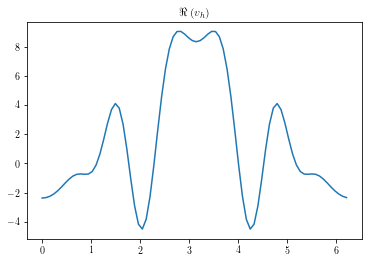

In [8]:
plt.plot(theta,np.real(v))
plt.title(r'$\Re\left(v_h\right)$');

## Step four: Use approximate boundary data (from step three) in the representation formula (from step one)
Plugging $v_h$ into the representation formula, and paramerising in the same way as before, gives
$$
u(x) \approx u_h(x) := u^i(x) - \int_0^{2\pi}\Phi(x,y(\theta))v_h(\theta)~\mathrm{d}\theta,\quad x\in\mathbb{R}^2\setminus\Omega.
$$
To be quick, we can use a one-point quadrature rule to evaluate this integral:
$$
u_h(x)\approx u^i(x) - h\sum_{m=1}^Nv_n\Phi(x,y(\theta_m)),\quad x\in\mathbb{R}^2\setminus\Omega.
$$

In [9]:
# create a method which approximates the solution at a point in the scattering domain
def sol_approx(x):
    val = ui(x)
    for n in range(N):
        val -= h*Phi(x,circle_map(theta[n]))*v[n]
    return val

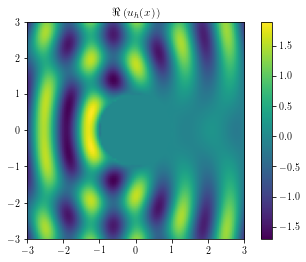

In [10]:
num_pixels =  100
t = np.linspace(-3,3,num_pixels)
X,Y = np.meshgrid(t,t)
u_h = np.zeros((num_pixels,num_pixels),dtype=complex)
for i in range(num_pixels):
    for j in range(num_pixels):
        if (X[i,j]**2+Y[i,j]**2)>1:
            u_h[i,j]=sol_approx([X[i,j],Y[i,j]])
        
sol = plt.imshow(np.real(u_h),extent =[t.min(), t.max(), t.min(), t.max()])
plt.colorbar(sol)
plt.title(r'$\Re\left(u_h(x)\right)$');

## Drawbacks of BEM compared with FEM
As mentioned in the introduction, the key advantage of BEM is that reduces the dimension of the problem by one. We saw that this resuls in a linear system, which is (usually) significantly smaller in size than we would expect with other methods. But we don't get this for free, there are two main drawbacks:
* The matrix entries requires the approximation singular integrals, and this can be difficult to do efficiently.
* The matrix will be dense.

The first of these two points is the main difficulty when implementing a BEM. If possible, use BEM software such as [bempp](https://bempp.com), where quadrature has been implemented carefully and efficiently. If you are hellbent on implementing your own BEM, get your quadrature routines from a colleage who has tried and tested them for similar problems. 

## Further details - variations on BEM
We have seen one example, but there are several other ways to implement a boundary element method. I will summarise these here:

### Choice of boundary condition
We used sound-soft/Dirichlet boundary condition for this example. Different choices of boundary condition will lead to a different BIE forrmulation.

### Choice of BIE
We used the BIE which arose naturally when we moved $x$ onto the boundary, in the sound-soft problem. This was the simplest to explain, however there exist values of $k$ for which this BIE is ill-posed, in which case our BEM has no chance of being accurate. Other BIEs exist for the same problem, some of which are well-posed for all values of $k$. The most commonly used is the **standard combined formulation**, which is well-posed for any $k$, and only requires a few extra lines of code.

The general form of a BIE is:
$$
Kv
=f,\quad\text{on }\Gamma
$$
where $K$ is an integral opeartor, which map functions on $\Gamma$ to functions on $\Gamma$, $f$ and $g$ are known. The unknown is $v$, which may be $v=\frac{\partial u}{\partial n}$ (sound-soft), $v=u$ (sound-hard), or  $v=\left(\begin{array}{c}
u\\\frac{\partial u}{\partial n}
\end{array}\right)$ (impedance).
### Choice of basis
We approximated the boundary data using a piecewise constant function. Higher degree polynomials can be used on a piecewise mesh, and on smooth obstacles such as these a fourier basis could be used, which removes the need for a mesh entirely. For obstacles with corners, the boundary data will be singular towards the corners, so graded meshes can be used. For certain geometries, specialised bases can be used, which incorporate known singular or oscillatory behaviour, to avoid grading.

### Choice of projection
We used a collocation BEM which forces the BIE to hold exactly at a fixed set of points, written generally this is:
$$
\sum_{m=1}^N K\varphi_m(x_n)=f(x_n),\quad\text{for }n=1,\ldots,N
$$

The main alternative is Galerkin BEM, which forces the BIE to hold in a weak sense when tested against our approximation space, like so:
$$
\sum_{m=1}^N(K\varphi_m,\varphi_n) = (f,\varphi_n),\quad\text{for }n=1,\ldots,N,
$$
where $(f,g)=\int_\Gamma f(x)\overline{g}(x)\mathrm{d}s(x)$.

Galerkin BEM has the advantage that we have guarenteed convergence for most problems, wheras collocation problems can be ill-posed for certain choices of collocation points, and nobody has a general rule for choosing them in a reliable way. The disadvantage of Galerkin is that the implementation requires an extra integral. So when $n=2$ Galerkin has two-dimensional integrals, and when $n=3$ Galerkin has four dimensional integrals. For this reason, engineers prefer collocation, and mathematicians perfer Galerkin.

Because of its efficiency, researchers are often looking for ways to tweak collocation so that its results are as accurate/reliable as Galerkin, but without the nasty double integrals. A well-established technique is the use of CHIEF points. Points inside the scatterer, where the field is known to be zero, are added to the approximation problem. A more recent area of research is [*oversampled collocation*](https://arxiv.org/abs/2103.17212), where the number of collocation points is larger than the number of basis functions. This can overcome the risks asociated with collocation.

### Choice of quadrature
In the coded example, we used a one-point quadrature rule for our integrals, which is the most basic approximation concievable. For smooth integrands $(m\neq n)$, [Gauss-Legendre quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature#Gauss–Legendre_quadrature) is very popular in practice, as this converges much faster. In higher dimensional integrals, a popular approach is to use Gauss quadrature in each direction. This is sub-optimal, cubature rules are the most efficient way to do this, but are rarely used in practice. 

For singular integrals $(m=n)$, grading can be used as a one-size-fits all approach. However, we often know the precise singular behaviour, so grading can be overkill. A more informed approach is that of singularity subtraction, where the singular part of the integrand is evaluated analytically, and the remaining part is evaluated using standard quadrature. A second informed approach is to use generalised Gaussian quadrature, which is designed to be accurate for integrals containing a certain type of singularity.

For singular double integrals, when the singularity is along the diagonal of the integration domain, the Duffy transform can be used to convert to two integrals over a square/cube/hypercube with singularities at the edges, making it more amenable to techniques for 1D singular integrals.

## Summary

* Certain scattering problems can be reforumlated as a problem on the boundary
* A BEM can be used to solve this problem on the boundary
* Certain BIEs and/or certain choices of collocation points can lead to numerical instabilities
* Care must be taken to ensure all integrals, especially the singular ones, are being evaluated to a sufficiet accuracy
* For this reason Galerkin (as opposd to collocation) BEM is harder to implement, and typically slower to run. But the results are more reliable